In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import wilcoxon

# Constants

In [2]:
lead_times = [0,1,2,3,4,5,6,7,8,9]
experiment_names = ["SIC_Attention_Res_UNet"]
benchmark_forecasts = ["Persistence_ice_charts", "Persistence_AMSR2", "TOPAZ", "TOPAZ_bias_corrected"]
#
date_min = "20220101"
date_max = "20221231"
period = date_min + "_" + date_max
#
path_output = "/lustre/storeB/users/cyrilp/COSI/Figures/Article/" 
if os.path.isdir(path_output) == False:
    os.system("mkdir -p " + path_output)
#
sizefont = 25
sizefont_legend = 19
linewidth = 3
alpha = 1
colors = ["green", "black", "indianred", "darkkhaki"]
bar_width = 0.175

# Functions

In [3]:
def read_dataset(experiment_names, period, lead_times):    
    Scores = {}
    #
    for exp in experiment_names:
        Frac_improved_IIEElength10 = {}
        for bf in benchmark_forecasts:
            Frac_improved_IIEElength10[bf] = np.full(len(lead_times), np.nan)
        #
        for lt, leadtime in enumerate(lead_times):
            #
            path_exp = "/lustre/storeB/project/copernicus/cosi/WP3/Data/Predictions_using_ice_charts_as_reference/" + exp + "/lead_time_" + str(leadtime) + "_days/scores/"
            Dataset = pd.read_csv(path_exp + "Scores_" + period + ".txt", delimiter = "\t")
            #
            for bf in benchmark_forecasts:
                Frac_improved_IIEElength10[bf][lt] = 100 * np.sum(Dataset["IIEElength_10_ML"] < Dataset["IIEElength_10_" + bf]) / len(Dataset["IIEElength_10_ML"])
            #
            for var in Dataset:
                if lt == 0:
                    Scores[exp + "_" + var] = np.full(len(lead_times), np.nan)
                    Scores[exp + "_" + var][lt] = np.mean(Dataset[var])
                else:
                    Scores[exp + "_" + var][lt] = np.mean(Dataset[var])
    #
    return(Frac_improved_IIEElength10, Scores)

In [4]:
def calculate_wilcoxon(experiment_1, experiment_2, period, lead_times, metrics = ["IIEElength_10"]):
    Wilcoxon = {}
    Pvalue = {}
    for met in metrics:
        Wilcoxon[met] = np.full(len(lead_times), np.nan)
        Pvalue[met] = np.full(len(lead_times), np.nan)
    #
    experiments = [experiment_1, experiment_2]
    for lt, leadtime in enumerate(lead_times):
        Datasets = {}
        for exp in experiments:
            path_exp = "/lustre/storeB/project/copernicus/cosi/WP3/Data/Predictions_using_ice_charts_as_reference/" + exp + "/lead_time_" + str(leadtime) + "_days/scores/"
            Datasets[exp] = pd.read_csv(path_exp + "Scores_" + period + ".txt", delimiter = "\t")
        #
        for met in metrics:
            Wilcoxon[met][lt], Pvalue[met][lt] = wilcoxon(Datasets[experiment_1][met + "_ML"], Datasets[experiment_2][met + "_ML"], zero_method = "wilcox", correction = False, alternative = "two-sided", mode = "auto")
    #
    return(Wilcoxon, Pvalue)

In [5]:
def make_figure_absolute(Frac_improved_IIEElength10, Scores, experiment_names, lead_times, sizefont, sizefont_legend, saving = False):
    #
    #colorscale = plt.cm.Paired
    #colors = colorscale(np.linspace(0, 1, len(experiment_names) + 1))
    lead_times_scores = [str(x) for x in (np.array(lead_times) + 1)]
    lead_times_fraction = np.array(lead_times) + 1
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, ax = plt.subplots(1, 2, figsize = (25, 10), facecolor = "w", edgecolor = "k")
    #
    ax = plt.subplot(121)
    l = ax.plot(lead_times_scores, 0.001 * Scores["SIC_Attention_Res_UNet_IIEElength_10_ML"], color = "blue", label = "Deep learning", linewidth = linewidth, alpha = alpha)
    l = ax.plot(lead_times_scores, 0.001 * Scores["SIC_Attention_Res_UNet_IIEElength_10_Persistence_ice_charts"], color = "green", label = "Persistence of ice charts", linewidth = linewidth, alpha = alpha)
    l = ax.plot(lead_times_scores, 0.001 * Scores["SIC_Attention_Res_UNet_IIEElength_10_Persistence_AMSR2"], color = "black", label = "Persistence of AMSR2 SIC", linewidth = linewidth, alpha = alpha)
    #l = ax.plot(lead_times_scores, 0.001 * Scores["SIC_Attention_Res_UNet_IIEElength_10_Anomaly_persistence"], color = "darkgrey", label = "Anomaly persistence", linewidth = linewidth, alpha = alpha)
    l = ax.plot(lead_times_scores, 0.001 * Scores["SIC_Attention_Res_UNet_IIEElength_10_TOPAZ"], color = "indianred", label = "TOPAZ4", linewidth = linewidth, alpha = alpha)
    l = ax.plot(lead_times_scores, 0.001 * Scores["SIC_Attention_Res_UNet_IIEElength_10_TOPAZ_bias_corrected"], color = "darkkhaki", label = "TOPAZ4 bias corrected", linewidth = linewidth, alpha = alpha)
    ax.grid(alpha = 0.4)
    ax.set_title("Ice edge distance error", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Distance error (km)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.legend(fontsize = sizefont_legend, loc = 'lower right', ncol = 1)
    ax.text(-0.1,-0.05, "a)", fontsize = sizefont, ha = "left", transform = ax.transAxes)
    #
    ax = plt.subplot(122)
    for i, bf in enumerate(benchmark_forecasts):
        label_str = bf.replace("TOPAZ", "TOPAZ4").replace("_", " ").replace("Persistence", "Persistence of").replace("AMSR2", "AMSR2 SIC")
        lead_times_i = lead_times_fraction - 2* bar_width + i * bar_width
        l = ax.bar(lead_times_i, Frac_improved_IIEElength10[bf], color = colors[i], label = label_str, width = bar_width, alpha = alpha)
    ax.set_title("Ice edge distance error", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Fraction of forecasts outperforming \n the benchmark forecasts (%)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_xticks(ticks = lead_times_fraction, labels = lead_times_fraction)
    ax.legend(fontsize = sizefont_legend, loc = "lower right", ncol = 1, framealpha = 1)
    ax.text(-0.1,-0.05, "b)", fontsize = sizefont, ha = "left", transform = ax.transAxes)
    #
    if saving == True:
        plt.savefig(path_output + "Scores_and_fraction_depending_on_lead_times_" + date_min + "_" + date_max + "_ice_charts_as_reference.png", bbox_inches = "tight")
    else:
        plt.show()

# Data processing 

<Figure size 640x480 with 0 Axes>

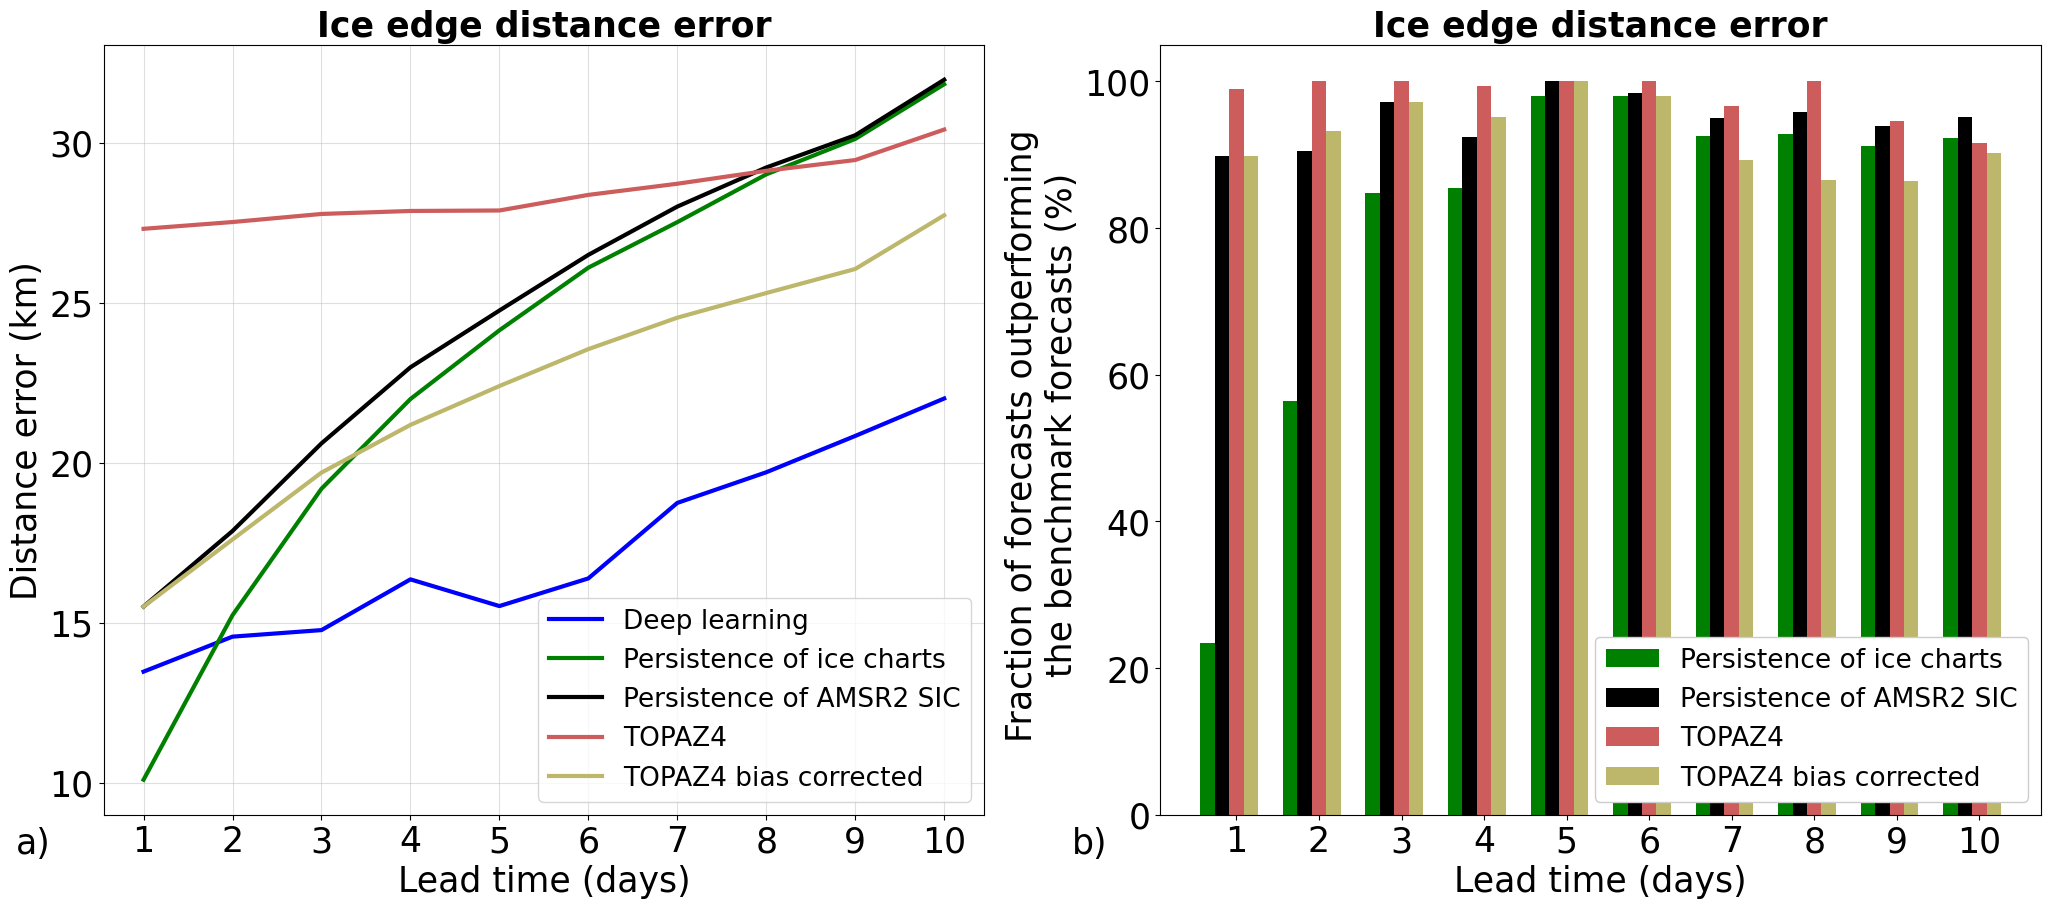

In [6]:
Frac_improved_IIEElength10, Scores = read_dataset(experiment_names, period, lead_times)
make_figure_absolute(Frac_improved_IIEElength10, Scores, experiment_names, lead_times, sizefont, sizefont_legend, saving = True)